In [1]:
import os
import cv2
import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import utils
reload(utils)

from keras import backend as K
from keras.layers import Input
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Lambda
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
/home/lysuhin/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
def add_conv_block(model, nb_layer, nb_filter, convsize, activation, pool_size):
    for layer in range(nb_layer):
        model.add(ZeroPadding2D(padding = (convsize[0] / 2,convsize[1] / 2)))
        model.add(Convolution2D(nb_filter=nb_filter, nb_row=convsize[0], nb_col=convsize[1], activation=activation))
    model.add(MaxPooling2D(pool_size=pool_size, strides=pool_size))
    
def add_fc_block(model, output_dim, activation, p_drop):
    model.add(Dense(output_dim=output_dim, activation=activation))
    model.add(Dropout(p_drop))
    
def add_input_layer(model, func, input_shape, output_shape):
    model.add(Lambda(function=func, input_shape=input_shape, output_shape=output_shape))

In [3]:
def create_nn(output_dim=10, preproc=None):
    
    model = Sequential()
    if preproc is None:
        add_input_layer(model, lambda x:x+0, (3, 128, 128), (3, 128, 128))
    else:
        add_input_layer(model, func=preproc, input_shape=(3, 128, 128), output_shape=(3, 128, 128))
    add_conv_block(model, nb_layer=2, nb_filter=8, convsize=(5,5), activation="relu", pool_size=(2,2))
    add_conv_block(model, nb_layer=2, nb_filter=16, convsize=(5,5), activation="relu", pool_size=(5,5))
    add_conv_block(model, nb_layer=2, nb_filter=32, convsize=(5,5), activation="relu", pool_size=(5,5))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    add_fc_block(model, output_dim=512, activation="tanh", p_drop=0.20)
    add_fc_block(model, output_dim=512, activation="tanh", p_drop=0.15)
    add_fc_block(model, output_dim=512, activation="tanh", p_drop=0.10)
    # it's enough, man
    
    model.add(Dense(output_dim=output_dim, activation="softmax"))
    
    return model

In [4]:
def fit(model, batches, val_batches, nb_epoch=1):
        """
        Fits the model on data yielded batch-by-batch by a Python generator.
        See Keras documentation: https://keras.io/models/model/
        """
        model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
                            validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [5]:
def save_weights(model, train_loss, train_acc, val_loss, val_acc, path="../weights/", id_=123):
    path_to_save = path + "weights_{}".format(id_)
    model.save_weights(path_to_save)
    info = "{};{};{};{};{};\n".format(id_, train_loss, train_acc, val_loss, val_acc)    
    if os.path.isfile(path + "results.csv"):
        with open(path + "results.csv", "a") as f:
            f.write(info)
    print "saved to {}".format(path_to_save)

In [6]:
def get_data_mean(train_path):
    train_batches = utils.get_batches(train_path, target_size=(128, 128))
    mean = 0.
    
    for fname in tqdm.tqdm(train_batches.filenames):
        image = plt.imread(train_path+fname)
        mean += image.mean(axis=(0,1))
    mean /= len(train_batches.filenames)
    mean = mean.reshape(3, 1, 1)
    print mean
    return mean

###################################################################################################################

In [7]:
train_path = "../data/crops/train/"
test_path = "../data/crops/test/"

In [8]:
#MEAN = get_data_mean(train_path=train_path)
MEAN = np.array([[[8.4947]], [[7.8407]], [[7.3567]]])

Добавим аугментацию по цветовым каналам:

Found 5989 images belonging to 17 classes.
Found 1982 images belonging to 17 classes.


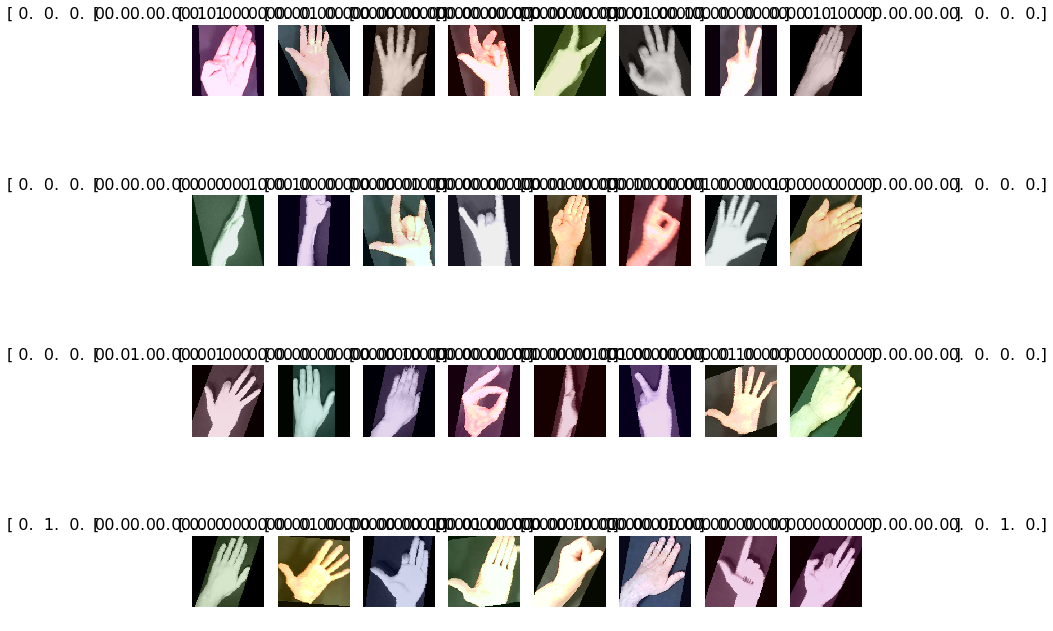

In [9]:
generator_aug = ImageDataGenerator(channel_shift_range=30., rotation_range=30)
train_batches = utils.get_batches(train_path, gen=generator_aug, batch_size=32, target_size=(128, 128))
test_batches = utils.get_batches(test_path, batch_size=32, target_size=(128, 128))
imgs, lbls = next(train_batches)
utils.plots(imgs, figsize=(12, 12), rows=4, titles=lbls)

In [10]:
net = create_nn(output_dim=17, preproc=lambda x:x-MEAN)
net.compile(optimizer=Adam(0.01), loss="categorical_crossentropy", metrics=["accuracy"])
net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 128, 128)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 132, 132)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 8, 128, 128)   608         zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 8, 132, 132)   0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [11]:
net.model.optimizer.lr.set_value(0.0005)
for decade in range(5):
    fit(net, train_batches, test_batches, nb_epoch=10)
    net.model.optimizer.lr.set_value(net.model.optimizer.lr.get_value() / 2)
    print("Divided LR by 2")

Epoch 1/10
5989/5989 [==============================] - 47s - loss: 2.5704 - acc: 0.1999 - val_loss: 1.1904 - val_acc: 0.5893
Epoch 2/10
5989/5989 [==============================] - 28s - loss: 1.1447 - acc: 0.6196 - val_loss: 0.5339 - val_acc: 0.8209
Epoch 3/10
5989/5989 [==============================] - 29s - loss: 0.7049 - acc: 0.7731 - val_loss: 0.3181 - val_acc: 0.8966
Epoch 4/10
5989/5989 [==============================] - 28s - loss: 0.5275 - acc: 0.8255 - val_loss: 0.2508 - val_acc: 0.9127
Epoch 5/10
5989/5989 [==============================] - 29s - loss: 0.4471 - acc: 0.8516 - val_loss: 0.1845 - val_acc: 0.9289
Epoch 6/10
5989/5989 [==============================] - 28s - loss: 0.3816 - acc: 0.8731 - val_loss: 0.1606 - val_acc: 0.9455
Epoch 7/10
5989/5989 [==============================] - 29s - loss: 0.3310 - acc: 0.8918 - val_loss: 0.1521 - val_acc: 0.9501
Epoch 8/10
5989/5989 [==============================] - 28s - loss: 0.2969 - acc: 0.9045 - val_loss: 0.1442 - val_acc:

In [12]:
def show_mistakes(test_batches, classnames_dict=None):
    ci = {}
    for key, value in test_batches.class_indices.items():
        ci.update({value: int(key)})
    total_mistakes = 0
    nb_batches = test_batches.n / test_batches.batch_size
    accuracy = 0.
    for j in range(nb_batches):
        images, labels_onehot = test_batches.next()
        predictions_onehot = net.predict_on_batch(images)
        true_labels = np.argmax(labels_onehot, axis=1)
        pred_labels = np.argmax(predictions_onehot, axis=1)
        wrong_ids = np.where(true_labels != pred_labels)[0]
        total_mistakes += len(wrong_ids)
        print("Test batch #{}:{} mistakes".format(j, len(wrong_ids)))
        if len(wrong_ids) > 0:
            wrong_images = images[wrong_ids]
            if classnames_dict is not None:
                titles = ["{} / {}".format(classnames_dict[ci[pred_labels[i]]], classnames_dict[ci[true_labels[i]]]) for i in wrong_ids]
            else:
                titles = ["{} / {}".format(pred_labels[i], true_labels[i]) for i in wrong_ids]
            utils.plots(wrong_images, figsize=(15, 4), titles=titles, fontsize=12)
            plt.show()
#         accuracy += len(wrong_ids) / test_batches.batch_size
    accuracy = 1. - (1. * total_mistakes / test_batches.n)
    print("Total mistakes: {}, accuracy: {}".format(total_mistakes, accuracy))
    return total_mistakes, accuracy

In [13]:
classnames_dict = {
    0: 'FIST-TOP',
    1: 'PALM-TOP',
    2: 'PALM-SIDE',
    3: 'RING',
    4: 'V',
    5: 'FIST-SIDE',
    6: 'THIRD-FINGER',
    7: 'GOAT',
    8: 'SECOND-FINGER',
    9: 'FOURTH-FINGER',
    10: 'DREI',
    11: 'POINTER',
    12: 'GOAT-INV',
    13: 'GUN',
    14: 'PALM-BOTTOM',
    15: 'FIRST-FINGER',
    16: 'FAN'
}

Test batch #0:0 mistakes
Test batch #1:1 mistakes


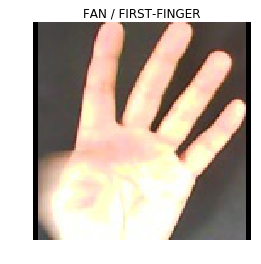

Test batch #2:0 mistakes
Test batch #3:0 mistakes
Test batch #4:1 mistakes


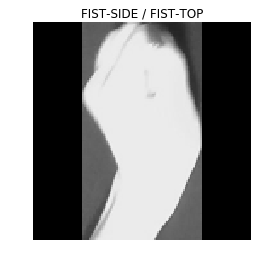

Test batch #5:1 mistakes


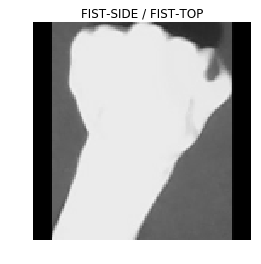

Test batch #6:0 mistakes
Test batch #7:0 mistakes
Test batch #8:0 mistakes
Test batch #9:0 mistakes
Test batch #10:0 mistakes
Test batch #11:1 mistakes


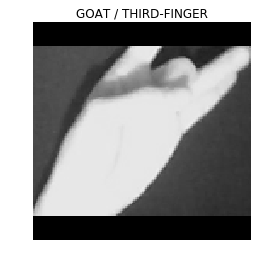

Test batch #12:0 mistakes
Test batch #13:0 mistakes
Test batch #14:1 mistakes


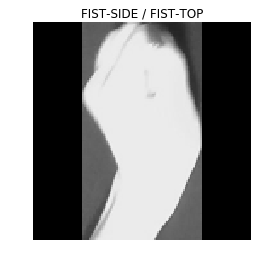

Test batch #15:0 mistakes
Test batch #16:0 mistakes
Test batch #17:1 mistakes


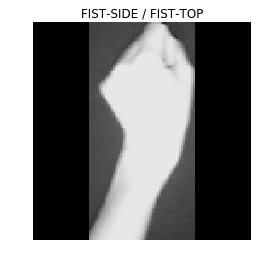

Test batch #18:0 mistakes
Test batch #19:0 mistakes
Test batch #20:1 mistakes


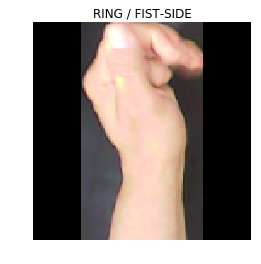

Test batch #21:0 mistakes
Test batch #22:0 mistakes
Test batch #23:0 mistakes
Test batch #24:0 mistakes
Test batch #25:0 mistakes
Test batch #26:1 mistakes


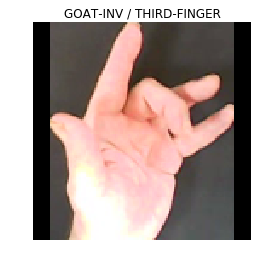

Test batch #27:0 mistakes
Test batch #28:0 mistakes
Test batch #29:0 mistakes
Test batch #30:0 mistakes
Test batch #31:1 mistakes


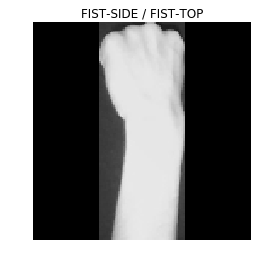

Test batch #32:1 mistakes


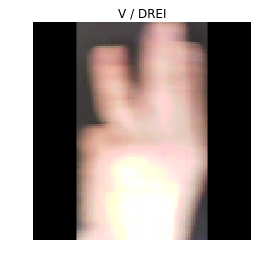

Test batch #33:0 mistakes
Test batch #34:0 mistakes
Test batch #35:0 mistakes
Test batch #36:0 mistakes
Test batch #37:1 mistakes


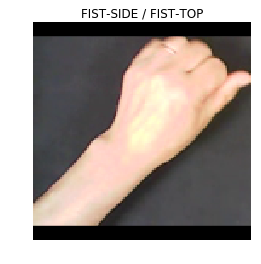

Test batch #38:0 mistakes
Test batch #39:0 mistakes
Test batch #40:1 mistakes


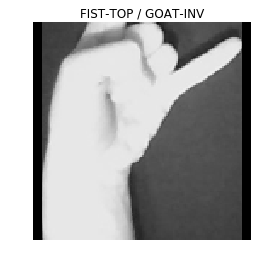

Test batch #41:1 mistakes


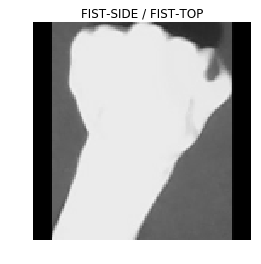

Test batch #42:1 mistakes


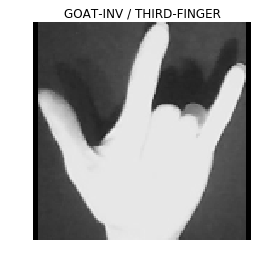

Test batch #43:1 mistakes


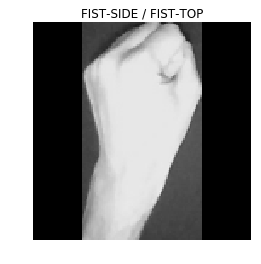

Test batch #44:0 mistakes
Test batch #45:0 mistakes
Test batch #46:0 mistakes
Test batch #47:0 mistakes
Test batch #48:0 mistakes
Test batch #49:0 mistakes
Test batch #50:0 mistakes
Test batch #51:1 mistakes


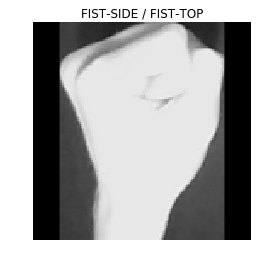

Test batch #52:0 mistakes
Test batch #53:2 mistakes


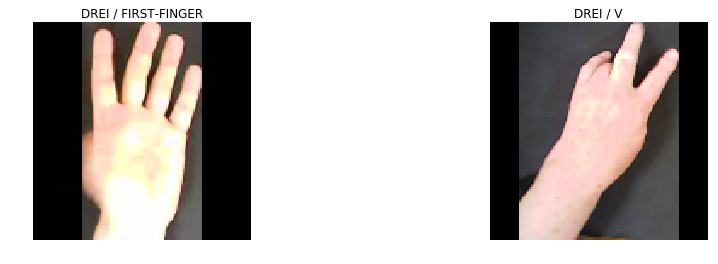

Test batch #54:0 mistakes
Test batch #55:0 mistakes
Test batch #56:1 mistakes


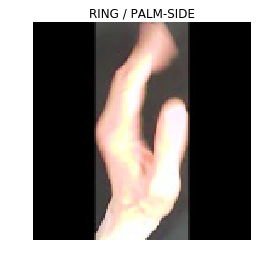

Test batch #57:2 mistakes


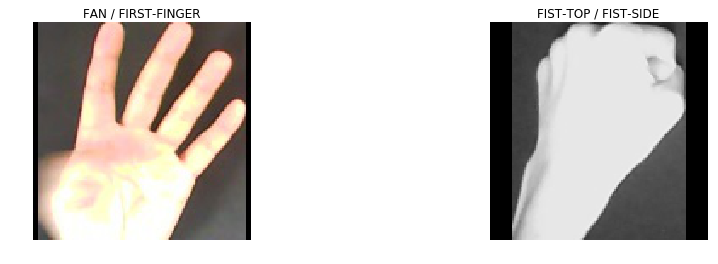

Test batch #58:0 mistakes
Test batch #59:0 mistakes
Test batch #60:0 mistakes
Total mistakes: 21, accuracy: 0.989404641776


(21, 0.9894046417759839)

In [14]:
show_mistakes(test_batches, classnames_dict=classnames_dict)

In [16]:
save_weights(net, 0.0501, 0.9818, 0.0423, 0.9899, id_=15)

saved to ../weights/weights_15
